In [11]:
import keras
keras.__version__

'2.2.2'

In [12]:
%%bash 
echo "Current project structure:"
echo "==== root ==================="
ls ../../
echo "==== data ==================="
ls ../../data
echo "==== models ================="
ls ../../models
echo "==== Phase-1-Xception-0.0.0 ="
ls ../../models/Phase1-Xception-0.0.0/

Current project structure:
==== root ===================
AUTHORS.rst
CHANGELOG.rst
LICENSE.txt
README.rst
build
data
dev_requirements.txt
docs
models
requirements.txt
setup.cfg
setup.py
src
tests
tox.ini
==== data ===================
0Triclinic_Anorthite
1Hexagonal
2Cubic_FCC
3BCC
4Tetragonal
5PrimitiveCubic
==== models =================
Phase1-Xception-0.0.0
ResNet50Model-0.0.0
==== Phase-1-Xception-0.0.0 =
model_checkpoint.h5


## Approach 0: Visualizing intermediate Activations
This approach is useful to understand how each layer transforms its input. 

In [13]:
"""Define project path constants"""
import os
import pathlib as pl


ROOT = pl.Path('..' + os.sep + '..')
DATA = ROOT / 'data'
MODELS = ROOT /'models'
TARGET_MODEL = MODELS / 'Phase1-Xception-0.0.0' / 'model_checkpoint.h5'

In [14]:
"""Read in model"""
from keras.models import load_model

def open_model(model_path=TARGET_MODEL):
    return load_model(model_path)

model = open_model()

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 246, 299, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 122, 149, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 122, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 122, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [15]:
%%bash
ls ../../data/1Hexagonal/

WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0011.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0039.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0040.tiff


In [16]:
img_path = DATA / '1Hexagonal' / 'WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff'


import os

def get_img_in_dir(root): 
    files = os.listdir(str(root))
    
    return [str(root) + os.sep + f for f in files if str(f).endswith('.tiff')]

get_img_in_dir(DATA / '1Hexagonal')

['../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0039.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0040.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0011.tiff']

In [17]:
import sys
sys.path.insert(0, os.path.abspath('..'))

from vecchio.make_data import filename_to_img
import numpy as np

img_single = filename_to_img(img_path)
img_tensor = np.expand_dims(img_single, axis=0)

imgs = [filename_to_img(f) for f in get_img_in_dir(DATA / '1Hexagonal')]

The EBSD pattern is represented as a matrix of floats between 0 and 1. 
When we show it as an image, the relative intensity values will be
represented with a color map

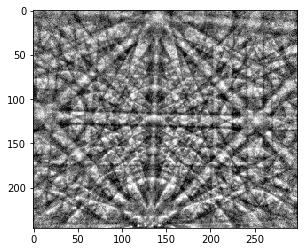

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_grey_cmap(flat_img):
    plt.imshow(flat_img[:, :, 0], cmap=cm.Greys_r)
    plt.show()

def save_grey_cmap(flat_img):
    plt.imsave(flat_img[:, :, 0], cmap=cm.Greys_r)

plot_grey_cmap(img_single)

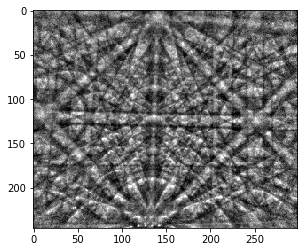

In [19]:
import numpy as np

def make_3_channel_img(flat_img):
    img_rgb = np.zeros((*flat_img.shape[:2], 3))
    tmp = np.squeeze(img_single)
    
    img_rgb[:, :, 0] = tmp
    img_rgb[:, :, 1] = tmp
    img_rgb[:, :, 2] = tmp
    
    return img_rgb

img_rgb = make_3_channel_img(img_single)

plt.imshow(img_rgb)

In [31]:
import vis


## Saliency Measure

In [32]:
import vis
from vis.utils import utils
from keras import activations

## Get the predictions layer index
layer_idx = utils.find_layer_idx(model, 'predictions')

## Swap softmax with linear layer
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

ModuleNotFoundError: No module named 'vis.utils'; 'vis' is not a package

In [14]:
from vis.visualization import visualize_saliency, overlay

for modifier in ['guided', 'relu']:
    plt.figure()
    plt.suptitle(modifier)
    grads = visualize_saliency(model, layer_idx, 
                               filter_indices=5, 
                               seed_input=img_single,
                               backprop_modifier=modifier
                              )

    plt.imshow(grads, cmap='jet')

ModuleNotFoundError: No module named 'vis.visualization'; 'vis' is not a package

## grad-CAM: Vanilla, Guided, Rectified

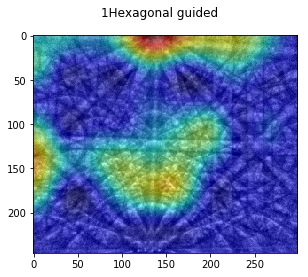

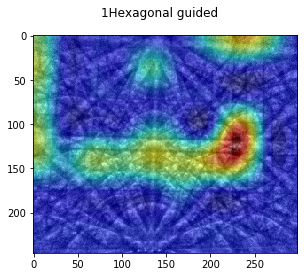

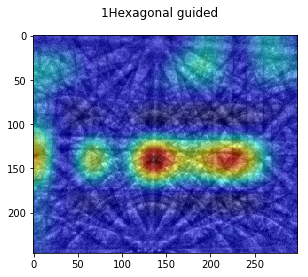

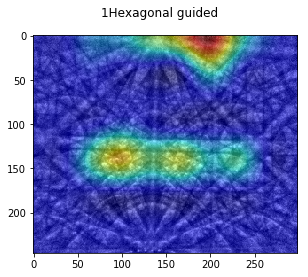

In [43]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam, overlay

def plot_gradcam(img, modifier='guided', title=''):
    plt.suptitle(title + ' ' + ('Vanilla' if modifier is None else modifier))
    grads = visualize_cam(model, -2, 
                          filter_indices=7,
                          seed_input=img,
                          backprop_modifier=modifier
                         )
    img_rgb = make_3_channel_img(img)
    # Overlay the heatmap onto original image.
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    plt.imshow(overlay(jet_heatmap, np.uint8(img_rgb*255), alpha=0.5))
    
    plt.show()

def plot_cam_of_class(classdir='1Hexagonal'):
    imgs = [filename_to_img(f) for f in get_img_in_dir(DATA / classdir)]
    for im in imgs:
        plt.figure()
        plot_gradcam(im, title=classdir)
        
plot_cam_of_class()

In [1]:
plot_cam_of_class('0Triclinic_Anorthite')


NameError: name 'plot_cam_of_class' is not defined

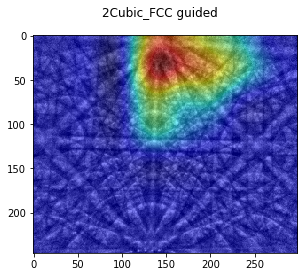

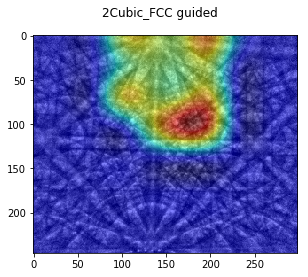

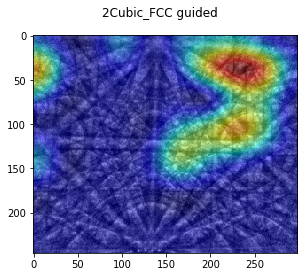

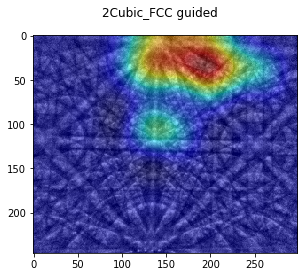

In [45]:
plot_cam_of_class('2Cubic_FCC')


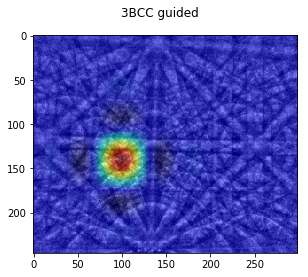

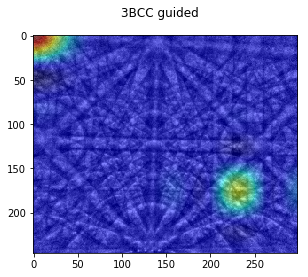

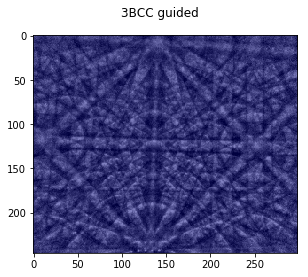

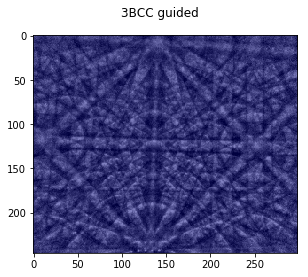

In [46]:
plot_cam_of_class('3BCC')



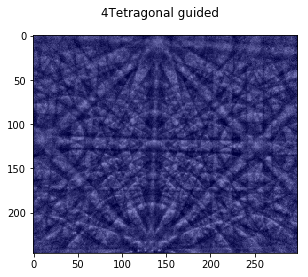

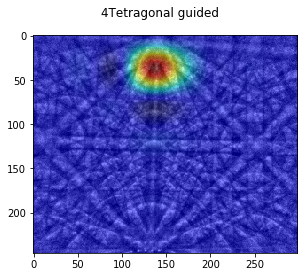

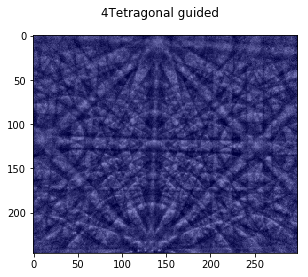

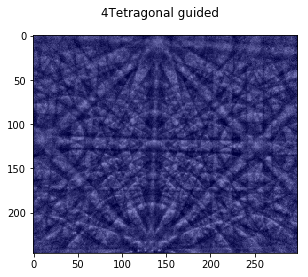

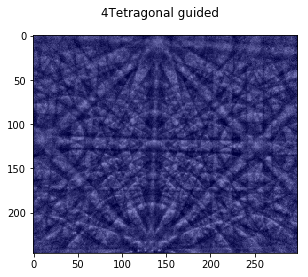

In [47]:
plot_cam_of_class('4Tetragonal')

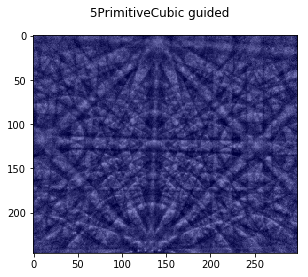

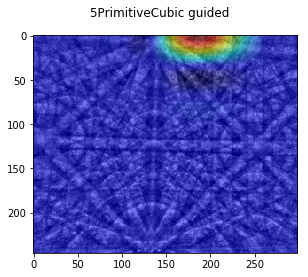

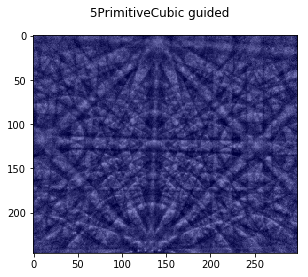

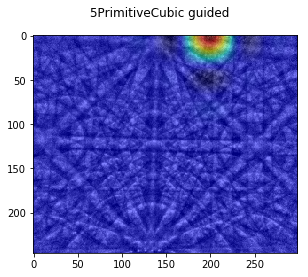

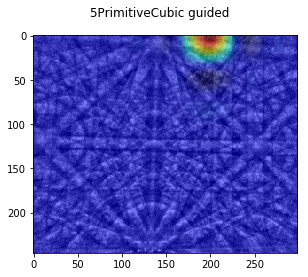

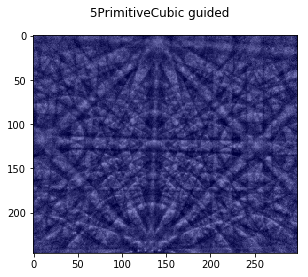

In [48]:
plot_cam_of_class('5PrimitiveCubic')


In [9]:
help(plt.imsave)

Help on function imsave in module matplotlib.pyplot:

imsave(*args, **kwargs)
    Save an array as in image file.
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    fname : str or file-like
        Path string to a filename, or a Python file-like object.
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename.
    arr : array-like
        An MxN (luminance), MxNx3 (RGB) or MxNx4 (RGBA) array.
    vmin, vmax: [ None | scalar ]
        *vmin* and *vmax* set the color scaling for the image by fixing the
        values that map to the colormap color limits. If either *vmin*
        or *vmax* is None, that limit is determined from the *arr*
        min/max value.
    cmap : matplotlib.colors.Colormap, optional
        For example, ``cm.viridis``.  If ``None``, defaults to the
        ``image.cmap`` rcParam.
    format : str
        One of the file extensions sup

In [23]:
help(str.endswith)

Help on method_descriptor:

endswith(...)
    S.endswith(suffix[, start[, end]]) -> bool
    
    Return True if S ends with the specified suffix, False otherwise.
    With optional start, test S beginning at that position.
    With optional end, stop comparing S at that position.
    suffix can also be a tuple of strings to try.

